Fitting 5 folds for each of 36 candidates, totalling 180 fits
MAE: 11.81
RMSE: 16.54
R2 Score: 0.03


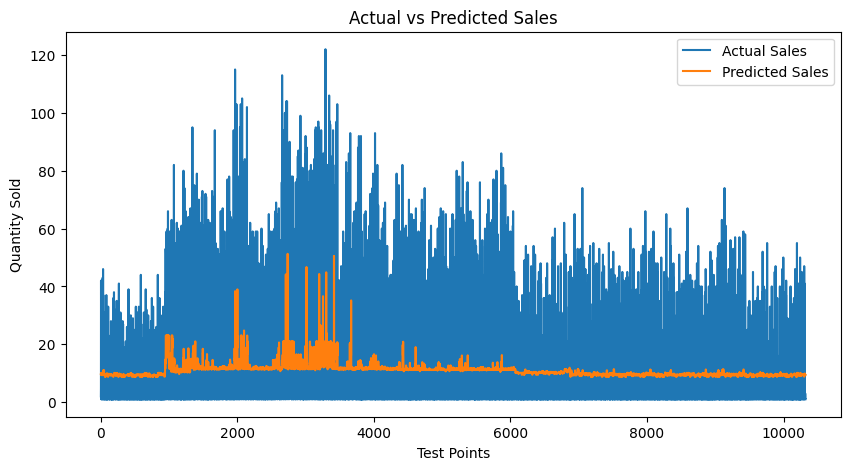

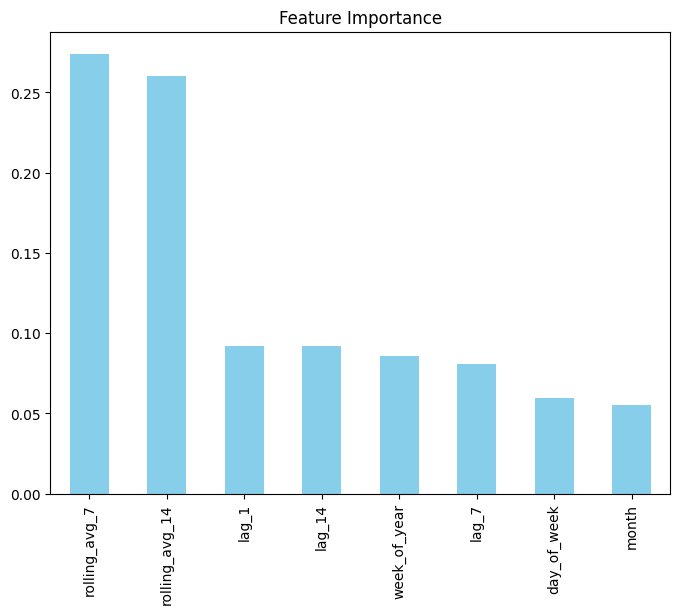

In [4]:
#IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

#DEFINING GOVERNING VARIABLES

feature_cols = ['day_of_week', 'month', 'week_of_year', 'lag_1', 'lag_7', 'lag_14', 'rolling_avg_7', 'rolling_avg_14']
target_col = 'qty_sold'
random_state = 42

#LOADING AND PREPARING DATA

data = pd.read_excel('/content/Beco data.xlsx')

data['date'] = pd.to_datetime(data['date'])

# FEATURE ENGINEERING

data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['week_of_year'] = data['date'].dt.isocalendar().week

data = data.sort_values(by=['item_id', 'date'])

for lag in [1, 7, 14]:
    data[f'lag_{lag}'] = data.groupby('item_id')[target_col].shift(lag)

for window in [7, 14]:
    data[f'rolling_avg_{window}'] = data.groupby('item_id')[target_col].shift(1).rolling(window=window).mean()

data = data.dropna()


#DECLARING FEATURES AND TARGET AND SPLITTING DATASET INTO TEST-TRAIN

X = data[feature_cols]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)


#MODEL INITIALISATION

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=random_state)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

#EVALUATION OF MODEL

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2 Score: {r2:.2f}')

#VISUALISATIONS

# Actual vs Predicted Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Test Points')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

# Feature Importance Plot
feature_importance = pd.Series(best_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.show()







